## Load_images

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Activation,MaxPool2D,Reshape,BatchNormalization,LeakyReLU,UpSampling2D,Flatten
from keras.activations import relu
from keras.optimizers import SGD
import math as math
from tqdm import tqdm_notebook as tqdm
from keras import backend as K 
import time
K.set_image_dim_ordering('th')

Load Image from NPZ 

In [5]:
f= np.load('omniglot.npz')
images= (f['images'])

Demo a simple image 


size of image is 104 x104


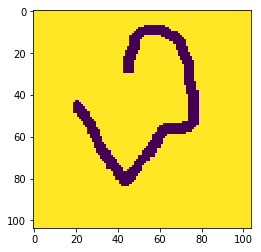

In [6]:
print "size of image is %d x%d" %images[2].shape
plt.imshow(images[2])
plt.show()
plt.close()

Generator 

In [7]:
def generator_model():
    model=Sequential()
    model.add(Dense(43264,input_shape=(100,)))
    model.add(Reshape((256, 13, 13)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.25))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(128,(5,5),strides=1,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(64,(5,5),strides=1,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(1,(4,4),strides=1,padding='same'))
    
    return model

In [8]:
G= generator_model()
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 43264)             4369664   
_________________________________________________________________
reshape_1 (Reshape)          (None, 256, 13, 13)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 13, 13)       52        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 13, 13)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 256, 26, 26)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 26, 26)       819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 26, 26)       104       
__________

In [9]:
def discriminator_model():
    model=Sequential()
    model.add(Conv2D(32,(5,5),input_shape=(1,104,104),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(128,(5,5),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(256,(5,5),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(2,2))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

In [10]:
D=discriminator_model()
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 104, 104)      832       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 104, 104)      416       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 104, 104)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 52, 52)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 52, 52)       102528    
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 52, 52)       208       
_________________________________________________________________
activation_2 (Activation)    (None, 128, 52, 52)       0         
__________

In [11]:
def Generator_plus_discriminator(generator,discriminator ):
    model=Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

In [12]:
GAN= Generator_plus_discriminator(G,D)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 1, 104, 104)       5395245   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 45227929  
Total params: 50,623,174
Trainable params: 5,395,063
Non-trainable params: 45,228,111
_________________________________________________________________


In [13]:
def combine_images(generated_images):
    num=generated_images.shape[0]
    width=int(math.sqrt(num))
    height=int(math.ceil(float(num)/width))
    shape = generated_images[2:]
    image=np.zeros((height*shape[0],width*shape[1]),
                  dtype = generated_images.dtype)
    for index,img in enumerate(generated_images):
        i = int(index/width)
        j = index%width
        image[i*shape[0]:(i+1)*shape[0],j*shape[1]:(j+1)*shape[1]]=image[0,:,:]

In [14]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[2:]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[0, :, :]
    return image


## Normalise the image  -------so the value is  between 0-1 

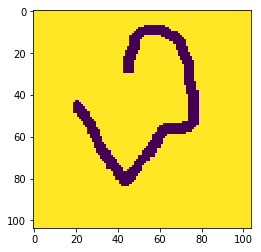

the shape of the image is 16121 x 104 x 104
the max of the image is 1.007874, the min of the image is -1.000000


In [15]:
f= np.load('omniglot.npz')
images= f['images']
images=images.astype('float')
images= (images-255/2)/(255/2)
plt.imshow(images[2])
plt.show()
print 'the shape of the image is %d x %d x %d' %images.shape
print 'the max of the image is %f, the min of the image is %f' % (images.max(),images.min())

# Training part 

In [16]:
G=generator_model()
D=discriminator_model()
discriminator_on_generator =  Generator_plus_discriminator(G,D)
generator_opti=SGD(lr=5e-3,momentum=0.9,nesterov=True)
discrim=SGD(lr=5e-3,momentum=0.9,nesterov=True)

G.compile(loss='binary_crossentropy',optimizer='SGD')
discriminator_on_generator.compile(loss='binary_crossentropy', optimizer=generator_opti)
D.trainable = True
D.compile(loss='binary_crossentropy',optimizer=discrim)
 
for epoch in (range(10)):
    print "Epoch is  = %d" %epoch
    print 'total batch = %d' % int(images.shape[0]/64)
    for index in tqdm(range(int(images.shape[0]/64))):
        noise = np.random.uniform(-1,1,6400)
        noise =np.reshape(noise,(64,100))
        image_batch = images[index*64:index*64+64]
        print str(image_batch.shape)
        G.predict(noise,verbose=0)

Epoch is  = 0
total batch = 251
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104, 104)
(64, 104

KeyboardInterrupt: 

In [57]:
x.shape

(64, 100)